# Implementing a RNN for Regression Problems

In [23]:
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(1)    
# reproducible
# Hyper Parameters
TIME_STEP = 10      
INPUT_SIZE = 1      
LR = 0.02           
# rnn time step
# rnn input size
# learning rate

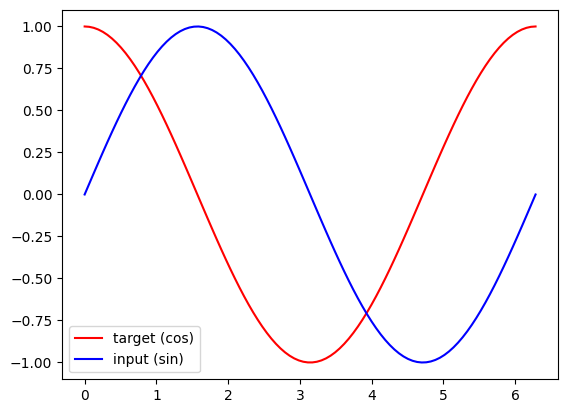

In [24]:
# show data
steps = np.linspace(0, np.pi*2, 100, dtype=np.float32)
x_np = np.sin(steps)    
# float32 for converting torch FloatTensor
y_np = np.cos(steps)
plt.plot(steps, y_np, 'r-', label='target (cos)')
plt.plot(steps, x_np, 'b-', label='input (sin)')
plt.legend(loc='best')
plt.show()

## Using PyTorch’s Built-In Functions 

In [25]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=32,      # rnn hidden unit
            num_layers=1,        # number of rnn layer
            batch_first=True,    # input & output will have batch size as 1st dimension. e.g. (batch, time_step, input_size)
        )
        self.out = nn.Linear(32, 1)

    def forward(self, x, h_state):
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, hidden_size)
        r_out, h_state = self.rnn(x, h_state)
        outs = []    # save all predictions
        for time_step in range(r_out.size(1)):    # calculate output for each time step
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), h_state

In [26]:
rnn = RNN()
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [27]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   #  optimize all cnn parameters
loss_func = nn.MSELoss()

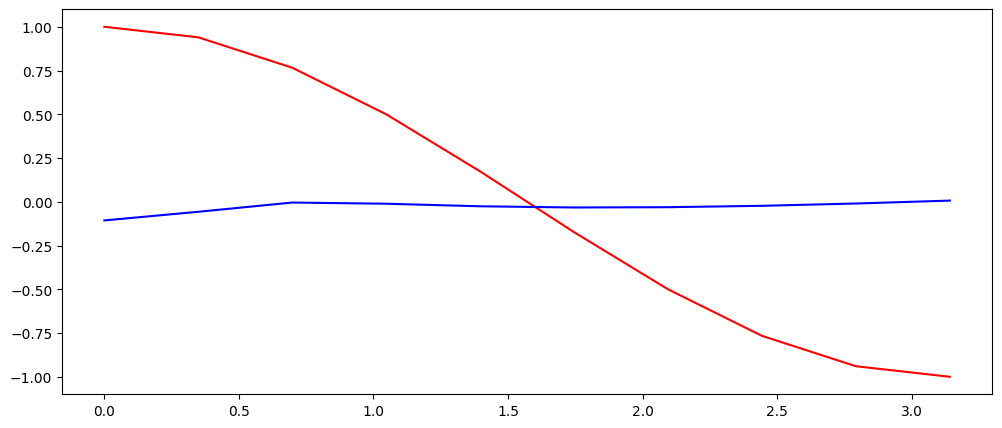

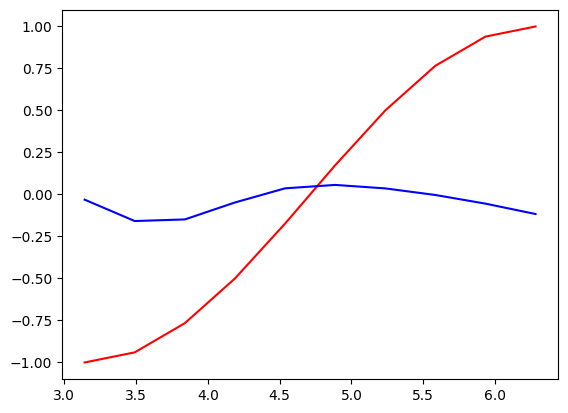

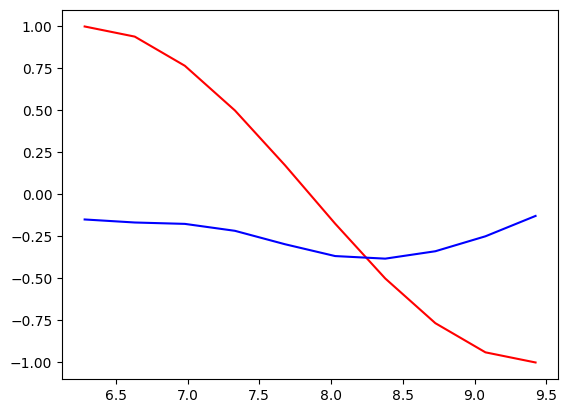

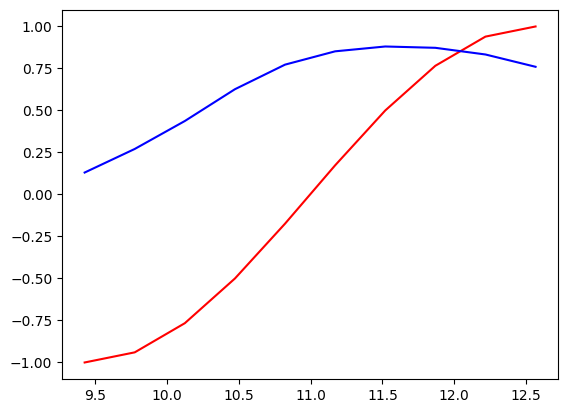

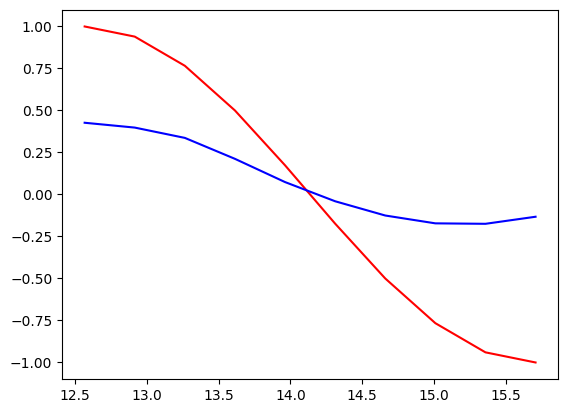

In [28]:
h_state = None  # for initial hidden state
plt.figure(1, figsize=(12, 5))
plt.ion()  # continuously plot

for step in range(5):
    start, end = step * np.pi, (step + 1) * np.pi  # time range
    # use sin predicts cos
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)
    x_np = np.sin(steps)  # float32 for converting torch FloatTensor
    y_np = np.cos(steps)
    x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis]))  # shape (batch, time_step, input_size)
    y = Variable(torch.from_numpy(y_np[np.newaxis, :, np.newaxis]))
    
    prediction, h_state = rnn(x, h_state)  # rnn output
    # !! next step is important !!
    h_state = Variable(h_state.data)  # repack the hidden state, break the connection from last iteration
    
    loss = loss_func(prediction, y)  # cross entropy loss
    optimizer.zero_grad()  # clear gradients for this training step
    loss.backward()  # backpropagation, compute gradients
    optimizer.step()  # apply gradients
    
    # plotting
    plt.plot(steps, y_np.flatten(), 'r-')
    plt.plot(steps, prediction.data.numpy().flatten(), 'b-')
    plt.draw()
    plt.pause(0.05)

# Working with Autoencoders

In [29]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
%matplotlib inline

In [30]:
torch.manual_seed(1)    
# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 64
LR = 0.005         
# reproducible
# learning rate
DOWNLOAD_MNIST = False
N_TEST_IMG = 5

In [31]:
# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,
    # this is training data
    transform=torchvision.transforms.ToTensor(),
    # Converts a PIL.Image or numpy.ndarray to
    #  torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,
    # download it if you don't have it
)

c:\Users\aaihs\anaconda3\envs\pt\lib\site-packages\torchvision\datasets\mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\Users\aaihs\anaconda3\envs\pt\lib\site-packages\torchvision\datasets\mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([60000, 28, 28])
torch.Size([60000])


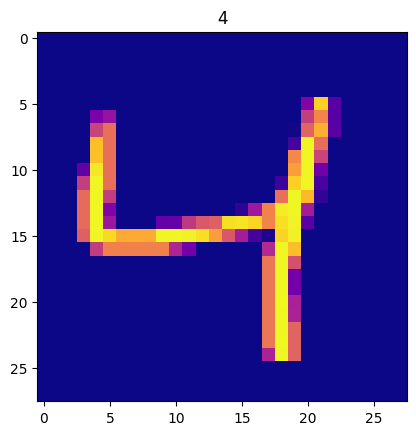

In [32]:
 # plot one example
print(train_data.train_data.size())     
# (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[2].numpy(), cmap='plasma')
plt.title('%i' % train_data.train_labels[2])
plt.show()

In [33]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3),   # compress to 3 features which can be visualized in plt
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [ ]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(1) 


train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)


test_data = dsets.MNIST(root='./mnist/', train=False, transform=transforms.ToTensor())
test_x = Variable(test_data.test_data, volatile=True).type(torch.FloatTensor)[:2000]/255.
# shape (2000, 28, 28) value in range(0,1)
test_y = test_data.test_labels.numpy().squeeze()[:2000]    
#  covert to numpy array


c:\Users\aaihs\anaconda3\envs\pt\lib\site-packages\torchvision\datasets\mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\aaihs\AppData\Local\Temp\ipykernel_14784\2538679559.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  test_x = Variable(test_data.test_data, volatile=True).type(torch.FloatTensor)[:2000]/255.
c:\Users\aaihs\anaconda3\envs\pt\lib\site-packages\torchvision\datasets\mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [35]:
autoencoder = AutoEncoder()
print(autoencoder)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()
# original data (first row) for viewing
view_data = Variable(train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): Tanh()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


Epoch:  0 | train loss: 0.2330
Epoch:  1 | train loss: 0.0492
Epoch:  2 | train loss: 0.0412
Epoch:  3 | train loss: 0.0416
Epoch:  4 | train loss: 0.0372
Epoch:  5 | train loss: 0.0397
Epoch:  6 | train loss: 0.0383
Epoch:  7 | train loss: 0.0398
Epoch:  8 | train loss: 0.0358
Epoch:  9 | train loss: 0.0363


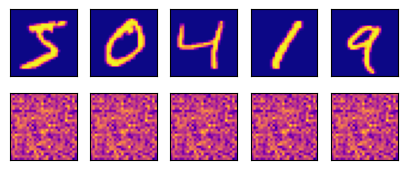

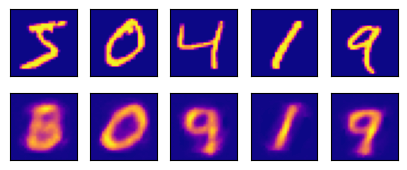

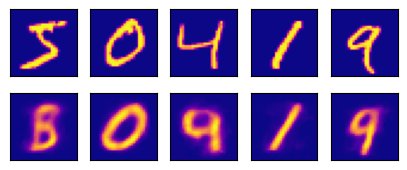

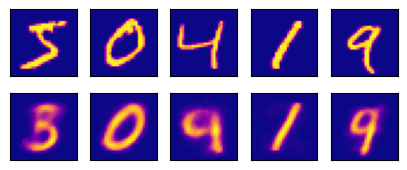

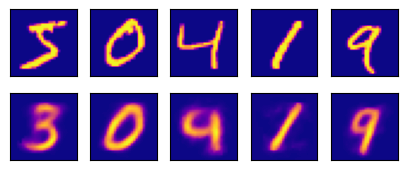

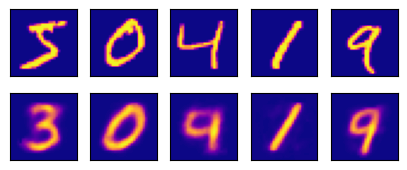

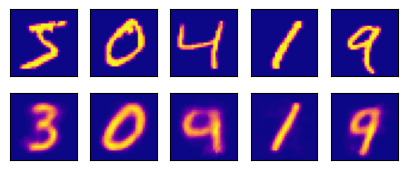

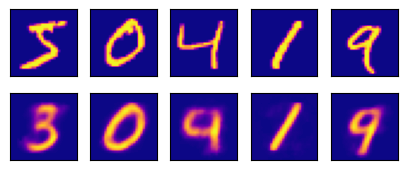

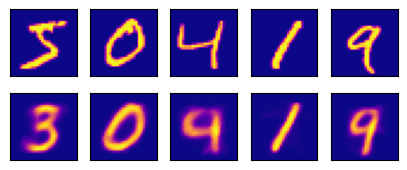

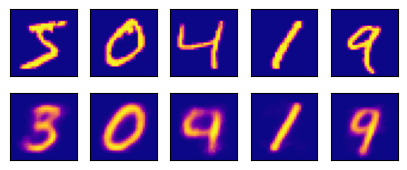

In [ ]:
# train the model

# train the model minimizing the loss function

for epoch in range(EPOCH):
    for step, (x, b_label) in enumerate(train_loader):
        b_x = Variable(x.view(-1, 28*28))   # batch x, shape (batch, 28*28)
        b_y = Variable(x.view(-1, 28*28))   # batch y, shape (batch, 28*28)
        b_label = Variable(b_label)
        encoded, decoded = autoencoder(b_x)
        
        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 1000 == 0:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data)
            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)
            # initialize figure
            f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
            for i in range(N_TEST_IMG):
                a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='plasma')
                a[0][i].set_xticks(()); a[0][i].set_yticks(())
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='plasma')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.draw(); 


#  Fine-Tuning Results Using Autoencoder

Epoch:  0 | train loss: 0.0363


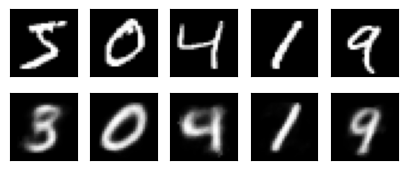

Epoch:  0 | train loss: 0.0370


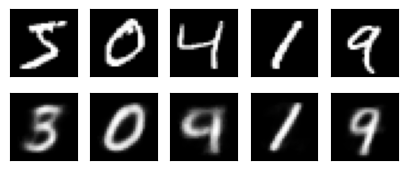

Epoch:  5 | train loss: 0.0377


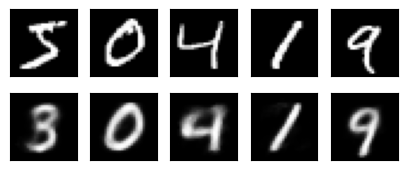

Epoch:  5 | train loss: 0.0382


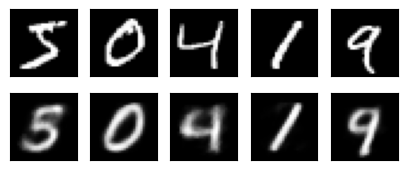

Epoch:  9 | train loss: 0.0349


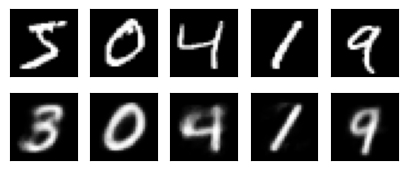

Epoch:  9 | train loss: 0.0362


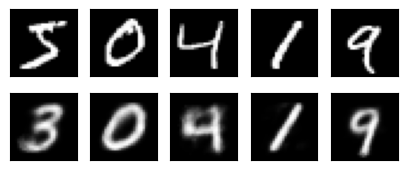

In [37]:
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x.view(-1, 28*28))   # batch x, shape (batch, 28*28)
        b_y = Variable(x.view(-1, 28*28))   # batch y, shape (batch, 28*28)
        b_label = Variable(y)               # batch label

        encoded, decoded = autoencoder(b_x)
        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 500 == 0 and epoch in [0, 5, EPOCH-1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data)
            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)
            # initialize figure
            f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
            for i in range(N_TEST_IMG):
                a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray')
                a[0][i].set_xticks(())
                a[0][i].set_yticks(())
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(())
                a[1][i].set_yticks(())
            plt.show()  # plt.pause(0.05)